<a href="https://colab.research.google.com/github/vbang247/python/blob/main/streaming_and_analyzing_tweets_using_tweepy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tweepy
import json
import firebase_admin
from firebase_admin import credentials
import pandas as pd
from pandas.io.json import json_normalize
from firebase_admin import db
import json
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import matplotlib

api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
api_secret_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
bearer_token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
access_token_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

authentication = tweepy.OAuthHandler(api_key, api_secret_key)
authentication.set_access_token(access_token, access_token_secret)
api = tweepy.API(authentication,wait_on_rate_limit=True)

In [ ]:
cred = credentials.Certificate("/content/drive/MyDrive/Colab Notebooks/creds.json")
firebase_admin.initialize_app(cred, {'databaseURL': "https://xxxxx-xxxx-xxxxx-xxxx.firebaseio.com/"})


In [ ]:

ref = db.reference("/tweets")
docs = ref.get()
#ref.delete()
print(type(docs))
#items = list(map(lambda x: {**x.to_dict(), 'id': x.id}, docs))
print(docs.values())
df = pd.json_normalize(docs.values()) # , columns=['id', 'email']
df.head()
#df.set_index('id', inplace=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,created_at,favorite_count,favorited,filter_level,id,id_str,is_quote_status,lang,quote_count,reply_count,retweet_count,retweeted,source,text,timestamp_ms,truncated,entities.hashtags,entities.user_mentions,retweeted_status.created_at,retweeted_status.display_text_range,retweeted_status.entities.hashtags,retweeted_status.entities.urls,retweeted_status.extended_tweet.display_text_range,retweeted_status.extended_tweet.entities.hashtags,retweeted_status.extended_tweet.entities.media,retweeted_status.extended_tweet.entities.urls,retweeted_status.extended_tweet.extended_entities.media,retweeted_status.extended_tweet.full_text,retweeted_status.favorite_count,retweeted_status.favorited,retweeted_status.filter_level,retweeted_status.id,retweeted_status.id_str,retweeted_status.is_quote_status,retweeted_status.lang,retweeted_status.possibly_sensitive,retweeted_status.quote_count,retweeted_status.reply_count,retweeted_status.retweet_count,retweeted_status.retweeted,...,place.full_name,place.id,place.name,place.place_type,place.url,retweeted_status.quoted_status.entities.hashtags,retweeted_status.quoted_status.extended_tweet.entities.user_mentions,retweeted_status.quoted_status.entities.media,retweeted_status.quoted_status.extended_entities.media,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,quoted_status.extended_tweet.entities.urls,retweeted_status.quoted_status.extended_tweet.entities.urls,quoted_status.in_reply_to_screen_name,quoted_status.in_reply_to_status_id,quoted_status.in_reply_to_status_id_str,quoted_status.in_reply_to_user_id,quoted_status.in_reply_to_user_id_str,retweeted_status.quoted_status.in_reply_to_screen_name,retweeted_status.quoted_status.in_reply_to_status_id,retweeted_status.quoted_status.in_reply_to_status_id_str,retweeted_status.quoted_status.in_reply_to_user_id,retweeted_status.quoted_status.in_reply_to_user_id_str,retweeted_status.extended_tweet.entities.symbols,entities.symbols,retweeted_status.entities.symbols,retweeted_status.scopes.followers,extended_tweet.entities.symbols,retweeted_status.place.bounding_box.coordinates,retweeted_status.place.bounding_box.type,retweeted_status.place.country,retweeted_status.place.country_code,retweeted_status.place.full_name,retweeted_status.place.id,retweeted_status.place.name,retweeted_status.place.place_type,retweeted_status.place.url
0,Sun Nov 07 20:36:37 +0000 2021,0,False,low,1457446915814084612,1457446915814084612,False,en,0,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",RT @HSELive: Face coverings help to reduce the...,1636317397441,False,"[{'indices': [57, 65], 'text': 'COVID19'}]","[{'id': 69298376, 'id_str': '69298376', 'indic...",Sun Nov 07 15:50:00 +0000 2021,"[0, 140]","[{'indices': [44, 52], 'text': 'COVID19'}]",[{'display_url': 'twitter.com/i/web/status/1…'...,"[0, 279]","[{'indices': [44, 52], 'text': 'COVID19'}]","[{'display_url': 'pic.twitter.com/pIcplYEKNb',...","[{'display_url': 'bit.ly/2WNr5xO', 'expanded_u...","[{'display_url': 'pic.twitter.com/pIcplYEKNb',...",Face coverings help to reduce the spread of #C...,25.0,False,low,1.457375e+18,1457374785541976065,False,en,False,5.0,3.0,11.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sun Nov 07 20:36:37 +0000 2021,0,False,low,1457446916216741888,1457446916216741888,True,en,0,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",RT @MaajidNawaz: the revolution will not be te...,1636317397537,False,"[{'indices': [79, 86], 'text': 'RESIST'}]","[{'id': 46078438, 'id_str': '46078438', 'indic...",Sun Nov 07 10:25:03 +0000 2021,NaN,"[{'indices': [62, 69], 'text': 'RESIST'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3072.0,False,low,1.457293e+18,1457293011063349253,True,en,NaN,17.0,40.0,950.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
#response = api.search(['covid'], lang='en', count=20)

class myStreamListener(tweepy.StreamListener):

  def on_connect(self):
    print("Connected to twitter")
  
  def on_data(self, data):
    json_ = json.loads(data)
    global count 
    count=count+1
    #print(count)
    if count > 50:
      return False
    if len(json_['entities']['hashtags']) and ('location' in json_['user'].keys() != None) and (json_['retweet_count'] != 0):
      print(json_)
      return True
      

#  def on_status(self, status):
 #   json_ = json.loads(status)
  #  print(json_)

  def on_error(self, status_code):
    if status_code == 420:
    #returning False in on_data disconnects the stream
      return False

count = 0
mystreamlistener = myStreamListener()
mystream = tweepy.Stream(auth=api.auth, listener=mystreamlistener) 
mystream.filter(track=['covid19'],languages=['en'])



Connected to twitter


[('DrEricDing', 1401), ('laloalcaraz', 346), ('Laurie_Garrett', 252), ('BernieSpofforth', 231), ('CDCgov', 214), ('ellymelly', 144), ('DrRobDavidson', 111), ('TigressEllie', 109), ('NSWHealth', 84), ('EpochTimes', 79)] 

[('COVID19', 5057), ('Covid19', 438), ('covid19', 405), ('NFL', 360), ('laloalcaraz', 349), ('pandejo', 347), ('AI', 152), ('coronavirus', 141), ('vaccination', 138), ('vaccinated', 122)] 



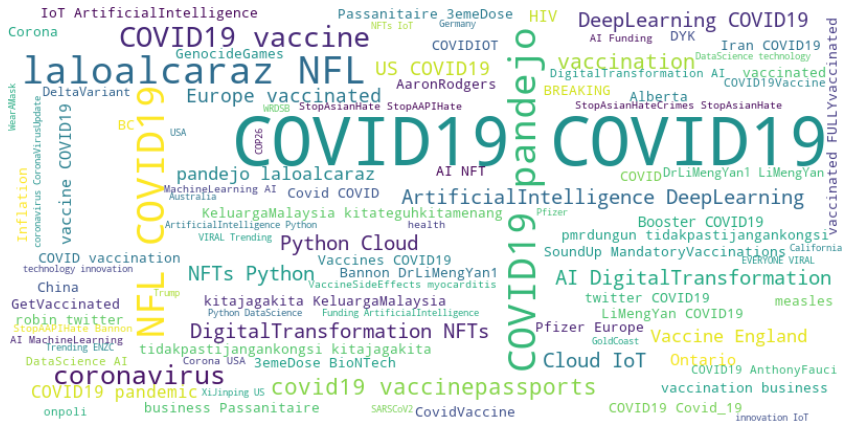

In [ ]:
ref = db.reference("/covid")
docs = ref.get()

df = pd.json_normalize(docs.values()) # , columns=['id', 'email']
pd.set_option('display.max_colwidth',1000)


# Extracting the text of all the tweets from the tweet object
texts = df['text'].to_list

# Extracting screen names of users tweeting about #WeLoveTheEarth
names = [user['screen_name'] for tweet in df['entities.user_mentions'].dropna() for user in tweet]

# Extracting all the hashtags being used when talking about this topic
hashtags = [hashtag['text'] for index in df['entities.hashtags'].dropna() for hashtag in index]

text = " ".join(hashtag for hashtag in hashtags)
wordcloud = WordCloud(max_words=100, background_color="white", width=800, height=400).generate(text)

# Counting occcurrences/ getting frequency dist of all names and hashtags
for item in [names, hashtags]:
    c = Counter(item) 
    # Inspecting the 10 most common items in c
    print (c.most_common(10), "\n")

plt.figure( figsize=(15,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [ ]:
df.columns.get_loc('retweeted_status.user.screen_name')

67

In [ ]:
df.groupby('user.location')['user.location'].count().sort_values(ascending=False).head(10)

user.location
                   3383
കേരളം               223
Los Angeles, CA     196
United States       129
New York, NY         90
California, USA      81
Canada               77
Australia            67
Washington, DC       64
USA                  63
Name: user.location, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


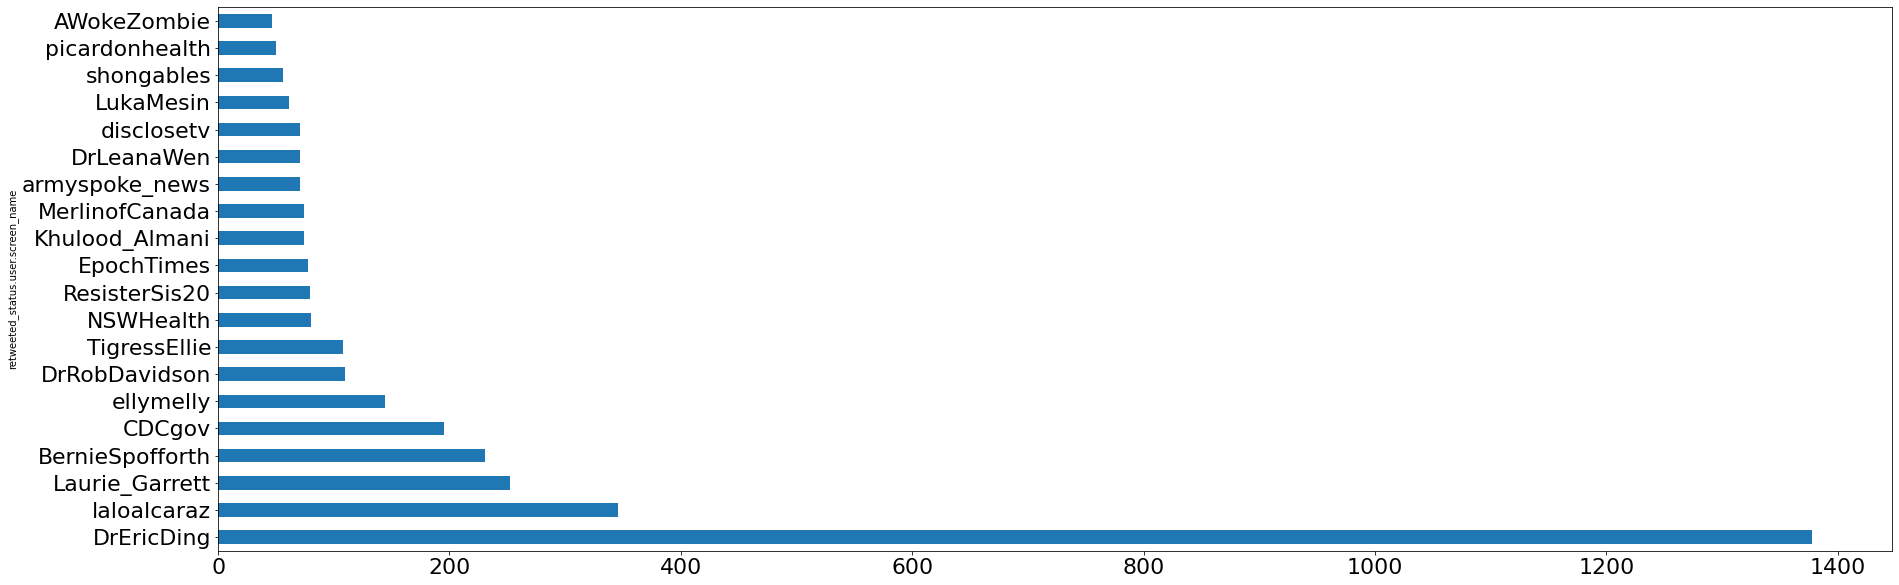

In [ ]:
plt.figure( figsize=(30,10) )
topretweeted = df.groupby('retweeted_status.user.screen_name')['retweeted_status.user.screen_name'].count().sort_values(ascending=False).head(20).sort_values(ascending=False).plot(kind='barh', fontsize=22)
print(topretweeted)

# for item in topretweeted:
#     c = Counter(item) 
#     # Inspecting the 10 most common items in c
#     print (c.most_common(10), "\n")

In [ ]:
df.loc[(df['retweeted_status.user.screen_name']=='DrKellyVictory') & (df['text'])] 

,created_at,favorite_count,favorited,id,id_str,is_quote_status,lang,possibly_sensitive,retweet_count,retweeted,source,text,truncated,entities.hashtags,entities.urls,entities.user_mentions,metadata.iso_language_code,metadata.result_type,retweeted_status.created_at,retweeted_status.entities.hashtags,retweeted_status.entities.urls,retweeted_status.favorite_count,retweeted_status.favorited,retweeted_status.id,retweeted_status.id_str,retweeted_status.is_quote_status,retweeted_status.lang,retweeted_status.metadata.iso_language_code,retweeted_status.metadata.result_type,retweeted_status.possibly_sensitive,retweeted_status.retweet_count,retweeted_status.retweeted,retweeted_status.source,retweeted_status.text,retweeted_status.truncated,retweeted_status.user.contributors_enabled,retweeted_status.user.created_at,retweeted_status.user.default_profile,retweeted_status.user.default_profile_image,retweeted_status.user.description,...,place.id,place.name,place.place_type,place.url,quoted_status.entities.user_mentions,quoted_status.in_reply_to_screen_name,quoted_status.in_reply_to_status_id,quoted_status.in_reply_to_status_id_str,quoted_status.in_reply_to_user_id,quoted_status.in_reply_to_user_id_str,quoted_status.place.bounding_box.coordinates,quoted_status.place.bounding_box.type,quoted_status.place.country,quoted_status.place.country_code,quoted_status.place.full_name,quoted_status.place.id,quoted_status.place.name,quoted_status.place.place_type,quoted_status.place.url,retweeted_status.quoted_status.entities.media,retweeted_status.quoted_status.extended_entities.media,retweeted_status.quoted_status.quoted_status_id,retweeted_status.quoted_status.quoted_status_id_str,retweeted_status.scopes.followers,retweeted_status.quoted_status.place.bounding_box.coordinates,retweeted_status.quoted_status.place.bounding_box.type,retweeted_status.quoted_status.place.country,retweeted_status.quoted_status.place.country_code,retweeted_status.quoted_status.place.full_name,retweeted_status.quoted_status.place.id,retweeted_status.quoted_status.place.name,retweeted_status.quoted_status.place.place_type,retweeted_status.quoted_status.place.url,entities.symbols,retweeted_status.entities.symbols,withheld_in_countries,withheld_scope,retweeted_status.withheld_scope,user.withheld_in_countries,user.withheld_scope
670,Thu Nov 11 03:02:58 +0000 2021,0,False,1458631309216165899,1458631309216165899,False,en,NaN,6445,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @DrKellyVictory: The FDA acknowledges that they predict more hospitalizations from myocarditis resulting from #COVID19 vaccines in 5-11…,False,"[{'indices': [113, 121], 'text': 'COVID19'}]",NaN,"[{'id': 815273012, 'id_str': '815273012', 'indices': [3, 18], 'name': 'Kelly Victory MD', 'screen_name': 'DrKellyVictory'}]",en,recent,Sun Nov 07 02:02:01 +0000 2021,"[{'indices': [93, 101], 'text': 'COVID19'}]","[{'display_url': 'twitter.com/i/web/status/1…', 'expanded_url': 'https://twitter.com/i/web/status/1457166418483548160', 'indices': [117, 140], 'url': 'https://t.co/pqoXWJ6XBA'}]",9904.0,False,1.457166e+18,1457166418483548160,False,en,en,recent,False,6445.0,False,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",The FDA acknowledges that they predict more hospitalizations from myocarditis resulting from #COVID19 vaccines in 5… https://t.co/pqoXWJ6XBA,True,False,Mon Sep 10 13:52:39 +0000 2012,True,False,"Physician, Cowgirl, Runner -- “Political correctness” is ruining us. Stop Big Government. The virus is real, the statistics are not! #FactsNotFear",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,Thu Nov 11 02:52:52 +0000 2021,0,False,1458628767346135044,1458628767346135044,False,en,NaN,6446,False,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @DrKellyVictory: The FDA acknowle

In [ ]:
ref = db.reference("/covid")
#ref.delete()

In [ ]:
ref = db.reference("/climatechange")
date_since="2021-11-01"
# Collect tweets
tweets = tweepy.Cursor(api.search,
                       q="#climatechange since:2021-11-01 until:2021-11-07",
                       lang="en", since=date_since).items(1000)

# Collect a list of tweets
[ref.push().set(tweet._json) for tweet in tweets]

docs = ref.get()
#print(type(docs))
#print(docs.values())
df = pd.json_normalize(docs.values())
df.shape

(1000, 304)

In [ ]:
df.created_at = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df['user.created_at'] = pd.to_datetime(df['user.created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df['created_at']

0     2021-11-06 23:59:50
1     2021-11-06 23:59:41
2     2021-11-06 23:59:41
3     2021-11-06 23:59:41
4     2021-11-06 23:59:41
              ...        
995   2021-11-06 21:44:21
996   2021-11-06 21:44:15
997   2021-11-06 21:43:55
998   2021-11-06 21:43:46
999   2021-11-06 21:43:42
Name: created_at, Length: 1000, dtype: datetime64[ns]

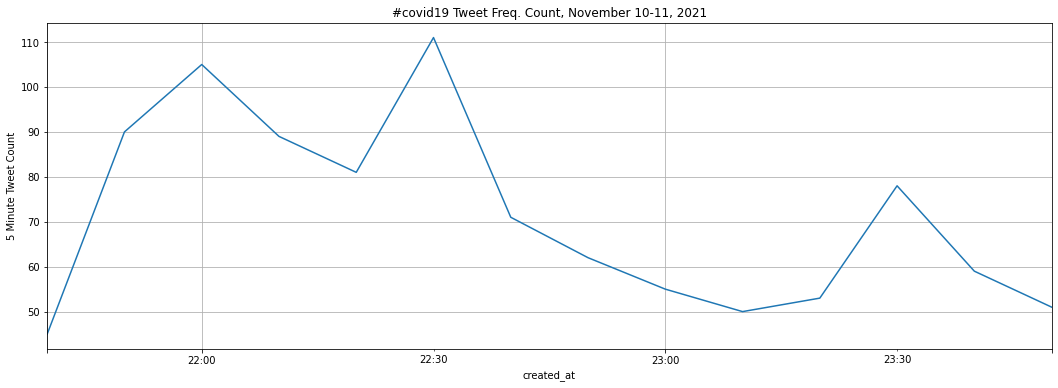

In [ ]:
tweet_df_5min = df.groupby(pd.Grouper(key='created_at', freq='10Min', convention='start')).size()
tweet_df_5min.plot(figsize=(18,6))
plt.ylabel('5 Minute Tweet Count')
plt.title('#covid19 Tweet Freq. Count, November 10-11, 2021')
plt.grid(True)

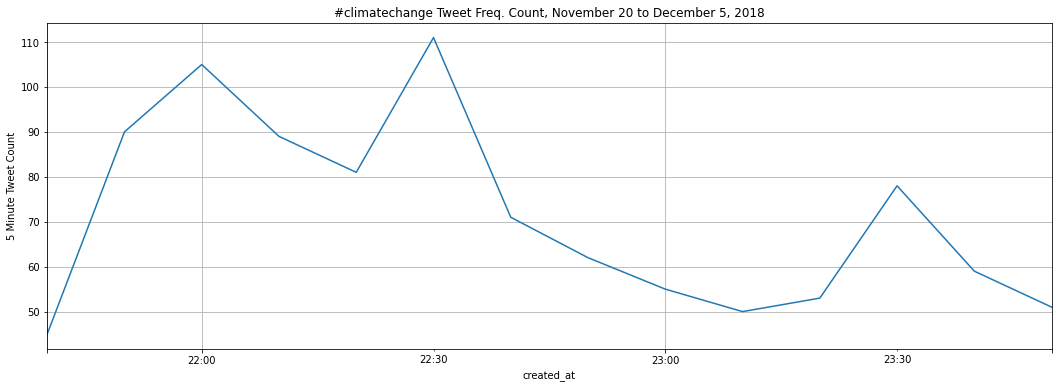

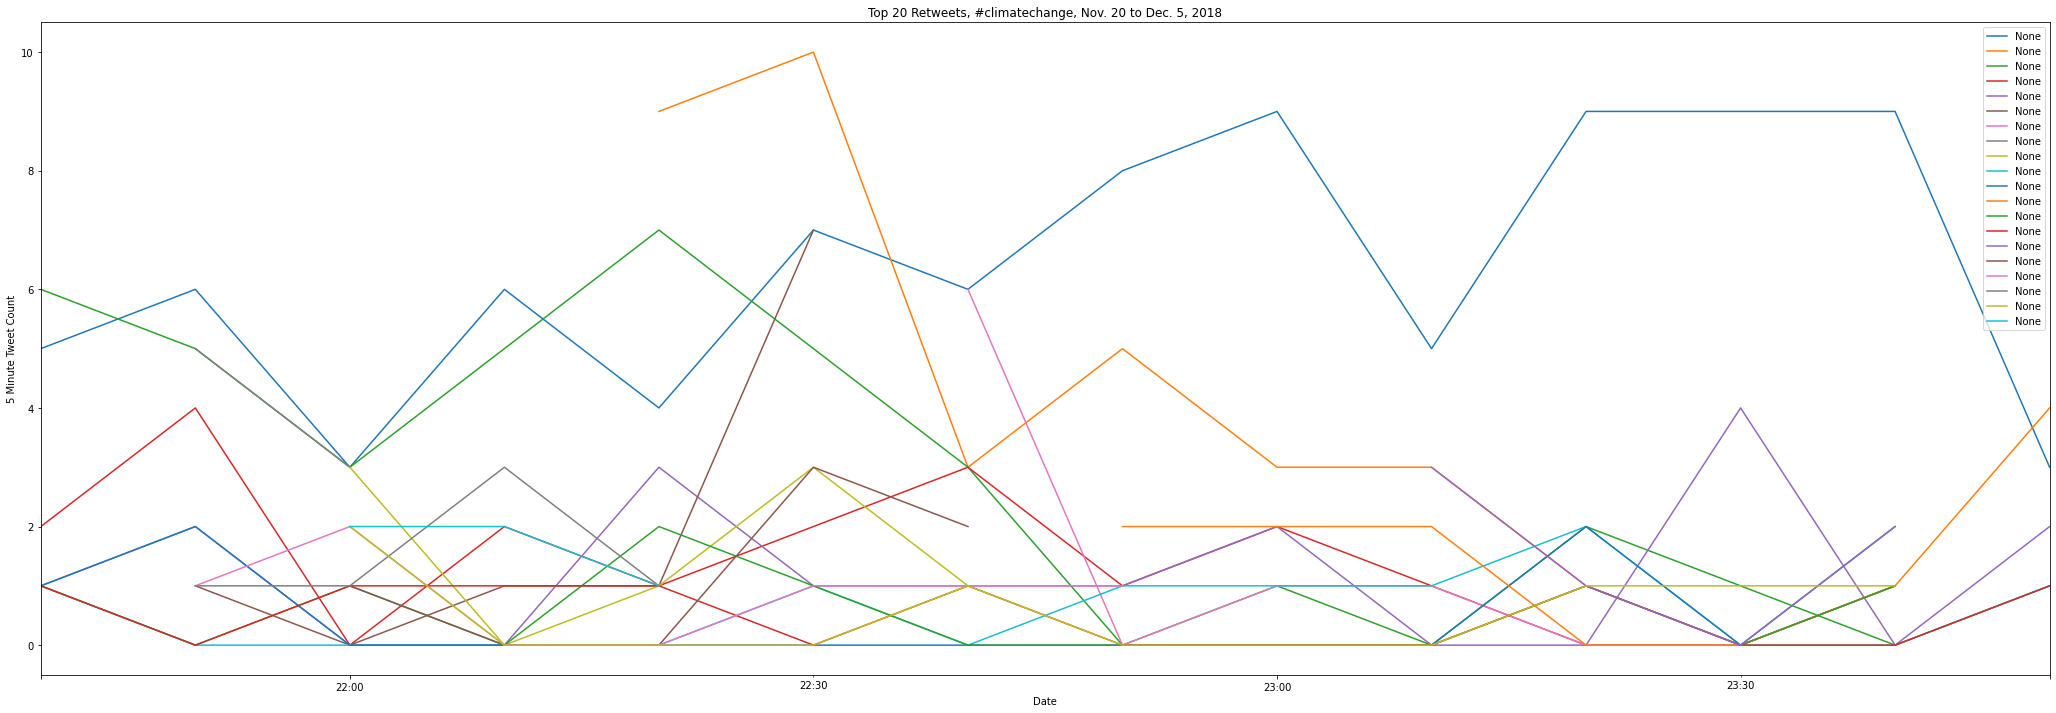

In [ ]:
from matplotlib import pyplot as plt


topretweets = df.groupby('retweeted_status.id').size().sort_values(ascending=False).reset_index()
#print(topretweets)
df.created_at = pd.to_datetime(df.created_at)
tweet_df_5min = df.groupby(pd.Grouper(key='created_at', freq='10Min', convention='start')).size()

tweet_df_5min.plot(figsize=(18,6))
plt.ylabel('5 Minute Tweet Count')
plt.title('#climatechange Tweet Freq. Count, November 20 to December 5, 2018')
plt.grid(True)

plt.figure(figsize=(36,12))
for top in range(0,20):
    tweetid = topretweets.iloc[top,0]
    climatechange_top_retweets = df[df['retweeted_status.id']==tweetid]
    climatechange_top_retweets.groupby(pd.Grouper(key='created_at', freq='10Min', convention='start')).size().plot()

plt.xlabel('Date')
plt.ylabel('5 Minute Tweet Count')
plt.legend()
plt.title('Top 20 Retweets, #climatechange, Nov. 20 to Dec. 5, 2018')
plt.savefig("climatechange_top20_retweet_timelines.png")




AxesSubplot(0.125,0.125;0.775x0.755)


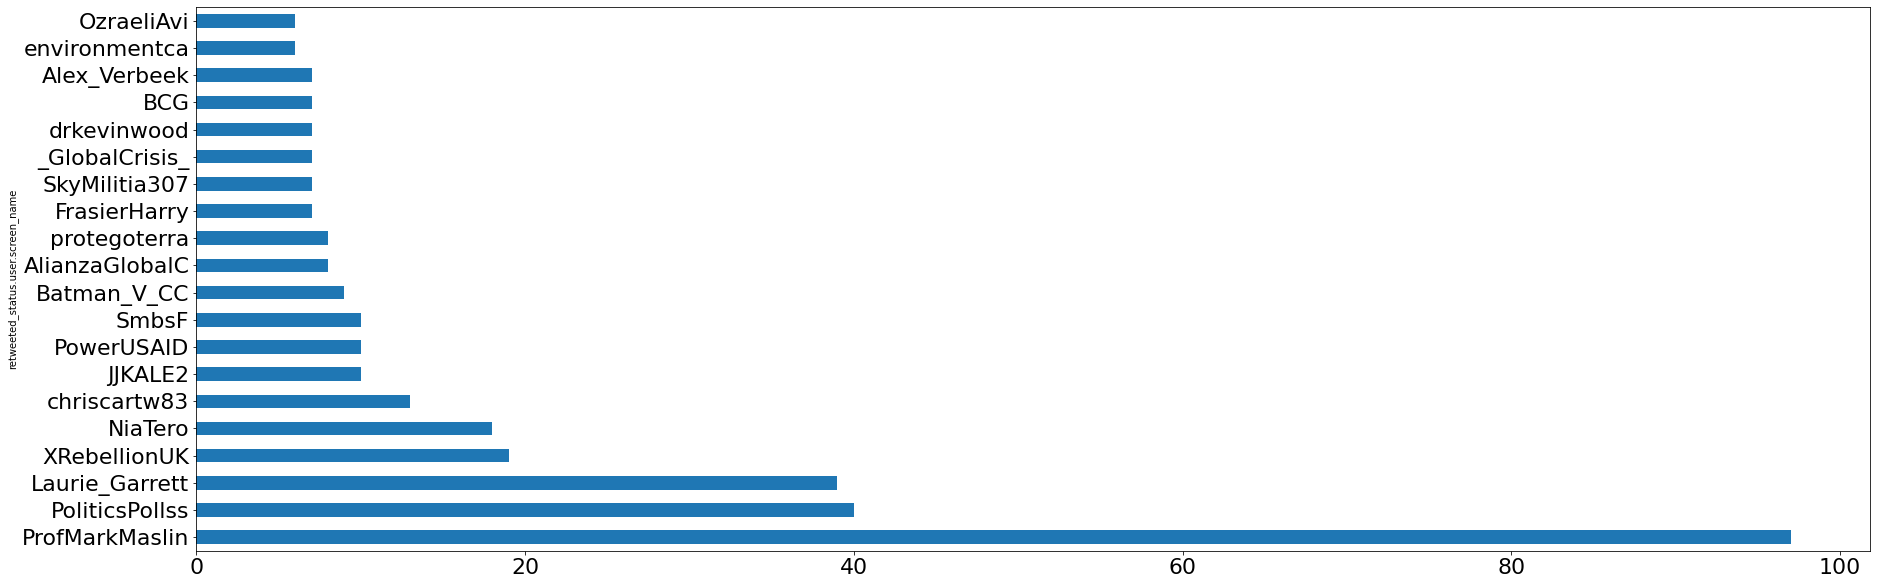

In [ ]:
plt.figure( figsize=(30,10) )
topretweeted = df.groupby('retweeted_status.user.screen_name')['retweeted_status.user.screen_name'].count().sort_values(ascending=False).head(20).sort_values(ascending=False).plot(kind='barh', fontsize=22)
print(topretweeted)

In [ ]:
print(df.shape)
# Extracting useful information from retweets
retweets = df[['retweeted_status.retweet_count','retweeted_status.favorite_count','retweeted_status.user.followers_count', 'retweeted_status.user.screen_name','text']]

cmap = {"retweeted_status.user.screen_name":"screen_name","text":"text","retweeted_status.user.followers_count":"follower","retweeted_status.retweet_count":"retweets","retweeted_status.favorite_count":"favourite"}
retweets.rename(columns=cmap,inplace=True)
retweets.groupby(['screen_name','text','follower']).sum().sort_values(ascending=False,by=['follower'])

(1000, 304)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,,,retweets,favourite
screen_name,text,follower,,
Reuters,RT @Reuters: Environmental groups protest in London's Trafalgar Square as the United Nations climate conference continues in Glasgow\n#COP26…,23983065.0,65.0,154.0
Tate,RT @Tate: Jenny Holzer’s #HURTEARTH illuminates #TateModern this weekend! Powerful words from leaders &amp; activists will be projected on to o…,4740939.0,522.0,1221.0
wef,"RT @wef: A third of humanity could be on the move if climate change isn’t curbed, say scientists https://t.co/r9alVPimiv #ClimateChange #CO…",4045664.0,580.0,1076.0
AFP,"RT @AFP: VIDEO: 🇦🇺 Hundreds rally in #Sydney for #COP26 Global Day of Action.\n\nFrom Paris to Sydney, Nairobi to Seoul, more than 200 events…",2083149.0,58.0,100.0
IMFNews,"RT @IMFNews: Today at #COP26 the focus is on nature, which can teach us important lessons about how we can cooperate to address global chal…",1925525.0,26.0,86.0
...,...,...,...,...
uzhvenko,"RT @uzhvenko: Dear Will, please don't remain indifferent to the crises that are going on in the world and whose power is increasing all the…",66.0,1.0,1.0
rodripuntriano,RT @rodripuntriano: Wonderful presentation. It's inspiring to listen to @AURORAmusic\nI feel grateful to be here after the panel on #climate…,56.0,18.0,96.0
SustainGudLife,RT @SustainGudLife: 28 hours People's #COP26 Happening @Clubhouse from 6th to 7th Nov 2021. #SustainableGoodLife #COP26 #NDCs #LearningSo…,38.0,15.0,6.0
